<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=300 HEIGHT=200>

<CENTER>
</br>
<p><font size="5">UE Big Data & Cloud Computing for Oceanography​</span></p>
<p><font size="4">  

​Xiayue SHEN​ 

Ilias SABIR​

Clément VAN STRAATEN​

Martin ROUESNE​

​ </font></p>
<p></p>
<p><font size="5">  Ocean Warmin contribution to Sea level rise </font></p>
</p></br>
</p>
</CENTER>

# Imports

In [1]:
import os, sys, urllib, tempfile
with tempfile.TemporaryDirectory() as tmpdirname:
    sys.path.append(tmpdirname)
    repo = "https://raw.githubusercontent.com/obidam/ds2-2023/main/"
    urllib.request.urlretrieve(os.path.join(repo, "utils.py"),
                               os.path.join(tmpdirname, "utils.py"))
    from utils import check_up_env
    check_up_env()

/tmp/tmp8z0afmj7/utils.py:39: UserWarning: 
Running on Google Colab, this set-up can take a few minutes
Be aware that your changes won't be saved unless you save this Notebooks on your G-Drive
  warnings.warn(


In [2]:
!pip install gsw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.0 MB/s eta 0:00:00


In [3]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 6.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


In [4]:
import xarray as xr
from intake import open_catalog
import gsw
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from intake import open_catalog
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


#### **Accessing Data**

In [5]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2023/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
ds = cat["en4"].to_dask()

# Correlation map

## Trend

In [6]:
#preaparation of data to calculate the trend for sea level anomalies
ssh = cat["sea_surface_height"].to_dask()
ssh_anomalies = []
for ti in range(0,200,10):
  ssh_sla = xr.DataArray(ssh.sla[ti,:,:], dims=["latitude", "longitude"])
  interpolated_ssh = ssh_sla.interp(latitude=ds.lat, longitude=ds.lon).compute()
  ssh_anomalies.append(interpolated_ssh)

ssh_anomalies = np.array(ssh_anomalies)

In [7]:
#computation of the trend of sea level anomalies
map_trend = np.zeros((173,360))
time = np.arange(0,200,10)
for lat in range(173):
  for lon in range(360):
    model = LinearRegression()
    model.fit(time.reshape(-1, 1), np.nan_to_num(ssh_anomalies[:,lat,lon]*1000)) #conversion meters to milimeters
    map_trend[lat,lon] = model.coef_

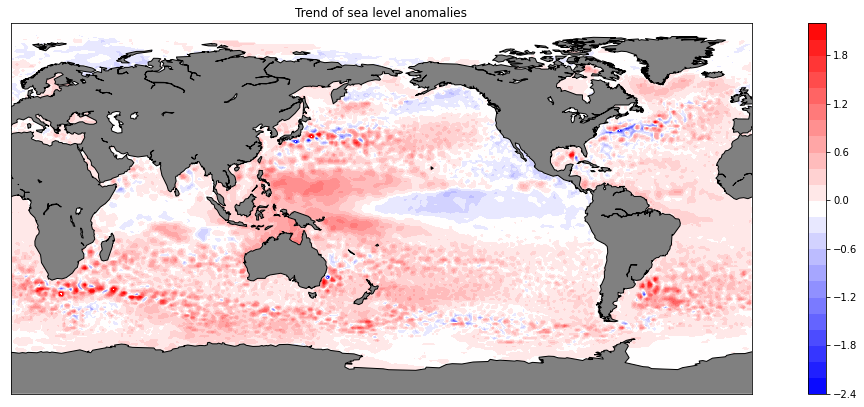

In [8]:
#plot trend of sea level anomalies
fig = plt.figure(figsize=(20, 15))
ax0 = fig.add_subplot(211)
level = np.arange(-2.4,2.4,0.2)
contourf = ax0.contourf(ds.lon, ds.lat, map_trend - np.nanmean(map_trend),levels = level,cmap='bwr')
m =Basemap(lat_0=90, lon_0=180)
m.drawcoastlines()
m.fillcontinents(color = 'grey')
plt.colorbar(contourf)
plt.title('Trend of sea level anomalies')

plt.show()

In [10]:
#computation of height for 10 timesteps ranging from 16/12/1998 to 16/12/2018 for steric heights (computation time : ~25mn)

t0 = 587  # 16/12/1998
tf = 827  # 16/12/2018 
step = 24 # 2 years

height_3d = []
for i in range(t0,tf,step):
  salinity = ds.salinity[i, :,:,:].compute()
  temperature = (ds.temperature[i, :,:,:]-273.15).compute()
  z, lat, lon = np.meshgrid(ds.depth, ds.lat, ds.lon, indexing='ij')

  p = gsw.p_from_z(-z, lat)

  absolute_salinity = gsw.SA_from_SP(salinity, p, lon, lat)
  conservative_temp = gsw.CT_from_t(absolute_salinity, temperature, p)

  height = gsw.geo_strf_dyn_height(absolute_salinity, conservative_temp, p)

  height_3d.append(height)


KeyboardInterrupt: ignored

In [ ]:
#compute the trend of steric heights
h_g = np.array(height_3d)
g = 9.7963 #m.s^-2
map_trend_steric = np.zeros((173,360))
time = np.arange(t0,tf,step)
for lat in range(173):
  for lon in range(360):
    model = LinearRegression()
    model.fit(time.reshape(-1, 1), (np.nan_to_num(h_g[:,0,lat,lon] - h_g[:,30,lat,lon]))/g)
    map_trend_steric[lat,lon] = model.coef_

In [ ]:
#plot the trend of steric heights
fig = plt.figure(figsize=(20, 15))
ax0 = fig.add_subplot(211)
level = np.arange(-1.5,1.5,0.01)
contourf = ax0.contourf(ds.lon, ds.lat, (map_trend_steric - np.nanmean(map_trend_steric))*1000,levels = level,cmap='bwr')
m =Basemap(lat_0=90, lon_0=180)
m.drawcoastlines()
m.fillcontinents(color = 'grey')
plt.colorbar(contourf)
plt.title('Trend of steric heights')

plt.show()

In [ ]:
# plot the difference of steric heights trends and sea level anomalies trends
fig = plt.figure(figsize=(20, 15))
ax0 = fig.add_subplot(211)

level = np.arange(-2,2,0.01)
map_1 = (map_trend - np.nanmean(map_trend))*1000
map_2 = (map_trend_steric - np.nanmean(map_trend_steric))*1000
contourf = ax0.contourf(ds.lon, ds.lat, map_1 - map_2 ,levels = level,cmap='bwr')
m =Basemap(lat_0=90, lon_0=180)
m.drawcoastlines()
m.fillcontinents(color = 'grey')
plt.colorbar(contourf)
plt.title('Difference between sea level anomalies and steric heights trends')

plt.show()

##Computation of correlation map

In [ ]:
#preparation of sea level anomalies data for correlation coefficients map
ssh_sla = xr.DataArray(ssh.sla[71:311:24,:,:], dims=["time", "latitude", "longitude"])
interpolated_ssh = ssh_sla.interp(latitude=ds.lat, longitude=ds.lon).compute()

In [ ]:
#computation of correlation coefficients map
map = np.zeros((173,360))
g = 9.7963 #m.s^-2
h_g = np.array(height_3d)
for lat in range(173):
  for lon in range(360):
    h = (np.nan_to_num(h_g[:,0,lat,lon] - h_g[:,30,lat,lon]))/g
    s = np.nan_to_num(interpolated_ssh[:,lat,lon])
    correlation = (np.corrcoef(h, s))[0,1]
    map[lat,lon] = correlation

In [ ]:
#plot the correlation coefficients map
fig = plt.figure(figsize=(20, 15))
ax0 = fig.add_subplot(211)
level = np.arange(-1,1,0.01)
contourf = ax0.contourf(ds.lon, ds.lat, map, levels=level, cmap='bwr')
m = Basemap(lat_0=90,lon_0=180)
m.drawcoastlines()
m.fillcontinents(color = 'grey')
plt.colorbar(contourf)
plt.title('Correlation map of sea level and steric heights anomalies 1998-2018')
plt.show()

#Temporal correlation

In [ ]:
# Computation of the interpolated_ssh
t0 = 71  # 16/12/1998
tf = 311  # 16/12/2018 
step = 24 # 2 years

ssh_sla = xr.DataArray(ssh.sla[t0:tf:step,:,:], dims=["time", "latitude", "longitude"])
interpolated_ssh = ssh_sla.interp(latitude=ds.lat, longitude=ds.lon)

In [ ]:
# Computation of the correlation between altimétrique values and computed height anomaly
corr=[]
for i in range(len(h_g)):
  height = h_g[i,:,:,:]/100
  corr.append(np.corrcoef( np.ravel(np.nan_to_num(interpolated_ssh[i,:,:])),np.ravel(np.nan_to_num(height[0,:,:] - height[30,:,:])))[0,1])

In [ ]:
# Plot of the temporal correlation 

t0 = 587  # 16/12/1998
tf = 827  # 16/12/2018 
step = 24 # 2 years

t = ds.time[t0:tf:step]
fig = plt.figure(figsize=(20, 10))
ax0 = fig.add_subplot(211)
graph = ax0.plot(t, corr)
plt.title("Correlation between altimétrique values and computed height anomaly", fontsize=25)
plt.savefig("Correlation_temporel.png")
plt.show()

#Time Series

## Functions

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
def get_time_series(latitude, longitude):

  # Creation of the returned arrays
  height_2d = []
  salinity_2d = []
  temperature_2d = []

  # Iterating on the entire timeline, each 3 month
  # This process allows to reduce the execution time
  for i in tqdm(range(0, len(ds.time), 3)):

    # Selection of the salinity and temperature for the timestamp
    salinity = ds.salinity[i, :, (ds.lat == latitude) , (ds.lon == longitude)].compute()
    temperature = (ds.temperature[i, :, (ds.lat == latitude), (ds.lon == longitude)] - 273.15).compute()
    # Selection of the longitude and latitude from the ds object
    ds_latitude = ds.lat[ds.lat == latitude].compute()
    ds_longitude = ds.lon[ds.lon == longitude].compute()

    # Creating a meshgrid
    z, lat, lon = np.meshgrid(ds.depth, ds_latitude, ds_longitude, indexing='ij')

    # Calculation of the differents velue needed to compute the height
    p = gsw.p_from_z(-z, lat)
    absolute_salinity = gsw.SA_from_SP(salinity, p, lon, lat)
    conservative_temp = gsw.CT_from_t(absolute_salinity, temperature, p)
    # Computation of the height
    height = gsw.geo_strf_dyn_height(absolute_salinity, conservative_temp, p)

    # Storing the results in the arrays
    temperature_2d.append(temperature)
    salinity_2d.append(salinity)
    height_2d.append(height)
  
  # Converting the arrays into numpy arrays
  salinity_2d = np.array(salinity_2d)
  temperature_2d = np.array(temperature_2d)
  height_2d = np.array(height_2d)

  return temperature_2d, salinity_2d, height_2d

##Point A - East Pacific

In [ ]:
# Defining the coordinates of the point
latitude = 30
longitude = 240

temperature_pointA, salinity_pointA, height_pointA = get_time_series(latitude, longitude)

In [ ]:
# Plot the results for Point A
fig = plt.figure(figsize=(20, 10))
time = ds.time[0:len(ds.time)-9:3]

# Comparing the Height anomaly and the Temperature
ax0 = fig.add_subplot(211)
plt.title("Evolution of the height anomaly and of the temperature in the East Pacific", fontsize = 25)
graph = ax0.plot(time, moving_average(height_pointA[:,0,0,0]-height_pointA[:,30,0,0], 4))
ax1 = ax0.twinx()
graph = ax1.plot(time, moving_average(temperature_pointA[:,0,0,0]-temperature_pointA[:,30,0,0], 4), c = "r")
ax0.set_ylabel('Height Anomaly (cm)', color='b')
ax1.set_ylabel('Temperature (°C)', color='r')

# Comparing the Height anomaly and the Salinity
ax0 = fig.add_subplot(212)
plt.title("Evolution of the height anomaly and of the salinity in the East Pacific", fontsize = 25)
graph = ax0.plot(time, moving_average(height_pointA[:,0,0,0]-height_pointA[:,30,0,0], 4))
ax1 = ax0.twinx()
graph = ax1.plot(time, moving_average(salinity_pointA[:,0,0,0]-salinity_pointA[:,30,0,0], 4), c = "r")
ax0.set_ylabel('Height Anomaly (cm)', color='b')
ax1.set_ylabel('Salinity (PSU)', color='r')

plt.savefig("Timeseries_East_Pacific.png")
plt.show()

## Point B - West Pacifique

In [ ]:
# Defining the coordinates of the point
latitude = 10
longitude = 150

temperature_pointB, salinity_pointB, height_pointB = get_time_series(latitude, longitude)

In [ ]:
# Plot the results for Point B
fig = plt.figure(figsize=(20, 10))
time = ds.time[0:len(ds.time)-9:3]

# Comparing the Height anomaly and the Temperature
ax0 = fig.add_subplot(211)
plt.title("Evolution of the height anomaly and of the temperature in the West Pacific", fontsize = 25)
graph = ax0.plot(time, moving_average(height_pointB[:,0,0,0]-height_pointB[:,30,0,0], 4))
ax1 = ax0.twinx()
graph = ax1.plot(time, moving_average(temperature_pointB[:,0,0,0]-temperature_pointB[:,30,0,0], 4), c = "r")
ax0.set_ylabel('Height Anomaly (cm)', color='b')
ax1.set_ylabel('Temperature (°C)', color='r')

# Comparing the Height anomaly and the Salinity
ax0 = fig.add_subplot(212)
plt.title("Evolution of the height anomaly and of the salinity in the West Pacific", fontsize = 25)
graph = ax0.plot(time, moving_average(height_pointB[:,0,0,0]-height_pointB[:,30,0,0], 4))
ax1 = ax0.twinx()
graph = ax1.plot(time, moving_average(salinity_pointB[:,0,0,0]-salinity_pointB[:,30,0,0], 4), c = "r")
ax0.set_ylabel('Height Anomaly (cm)', color='b')
ax1.set_ylabel('Salinity (PSU)', color='r')

plt.savefig("Timeseries_West_Pacific.png")
plt.show()

## Point C - North Atlantic

In [ ]:
# Defining the coordinates of the point
latitude = 50
longitude = 325

temperature_pointC, salinity_pointC, height_pointC = get_time_series(latitude, longitude)

In [ ]:
# Plot the results for Point C
fig = plt.figure(figsize=(20, 10))
time = ds.time[0:len(ds.time)-9:3]

# Comparing the Height anomaly and the Temperature
ax0 = fig.add_subplot(211)
plt.title("Evolution of the height anomaly and of the temperature in the North Atlantic", fontsize = 25)
graph = ax0.plot(time, moving_average(height_pointC[:,0,0,0]-height_pointC[:,30,0,0], 4))
ax1 = ax0.twinx()
graph = ax1.plot(time, moving_average(temperature_pointC[:,0,0,0]-temperature_pointC[:,30,0,0], 4), c = "r")
ax0.set_ylabel('Height Anomaly (cm)', color='b')
ax1.set_ylabel('Temperature (°C)', color='r')

# Comparing the Height anomaly and the Salinity
ax0 = fig.add_subplot(212)
plt.title("Evolution of the height anomaly and of the salinity in the North Atlantic", fontsize = 25)
graph = ax0.plot(time, moving_average(height_pointC[:,0,0,0]-height_pointC[:,30,0,0], 4))
ax1 = ax0.twinx()
graph = ax1.plot(time, moving_average(salinity_pointC[:,0,0,0]-salinity_pointC[:,30,0,0], 4), c = "r")
ax0.set_ylabel('Height Anomaly (cm)', color='b')
ax1.set_ylabel('Salinity (PSU)', color='r')

plt.savefig("Timeseries_North_Atlantic.png")
plt.show()